In [1]:
import cptac
import pandas as pd
from scipy import stats
import numpy as np
import statsmodels.stats.multitest as ssm

In [2]:
ccrcc = cptac.Ccrcc()
en = cptac.Endometrial()
luad = cptac.Luad()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-2-5c25f03e6d4a>, line 5)


In [3]:
def find_norm_tumor_corr_effect(cancer_type, gene):
    tumor = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'tumor', flatten = True)
    normal = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'normal', flatten = True)
    tumor = tumor.dropna()
    normal = normal.dropna()
    if len(normal) < 2 or len(tumor) < 2:
        return float("NaN"), float("NaN"), float("NaN")
    tumor.columns = ['proteomics', 'transcriptomics']
    normal.columns = ['proteomics', 'transcriptomics']
    groups = ['tumor'] * len(tumor)
    groups.extend(['normal']*len(normal))
    prot_list = list(tumor['proteomics'])
    prot_list.extend(list(normal['proteomics']))
    trans_list = list(tumor['transcriptomics'])
    trans_list.extend(list(normal['transcriptomics']))
    gene_df = pd.DataFrame({'Type': groups, 'Proteomics': prot_list, 'Transcriptomics': trans_list})
    is_tum = gene_df['Type'] == 'tumor'
    is_norm = gene_df['Type'] == 'normal'
    tum_cor, tum_pval = stats.pearsonr(gene_df[is_tum]['Proteomics'], gene_df[is_tum]['Transcriptomics'])
    norm_cor, norm_pval = stats.pearsonr(gene_df[is_norm]['Proteomics'], gene_df[is_norm]['Transcriptomics'])
    return tum_cor, tum_pval, norm_cor, norm_pval, gene_df  

In [4]:
def get_cancer_string(cancer):
    if cancer == ccrcc:
        return "ccrcc"
    if cancer == en:
        return 'endometrial'
    if cancer == luad:
        return 'luad'
    if cancer == hnscc:
        return 'hnscc'
    if cancer == lscc:
        return 'lscc'

See https://statisticsbyjim.com/regression/comparing-regression-lines/

In [5]:


from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
import rpy2.robjects as robj
import pandas as pd
def linear_model(data, Input, Output, Condition):
    try:
        stats = importr('stats')
        base = importr('base')
        pandas2ri.activate()
        r_df = pandas2ri.py2rpy(data)
        pandas2ri.deactivate()
        formula = '{y}~{x}*{condition}'.format(y = Output, x = Input, condition = Condition)
        lm = stats.lm(formula, r_df)
        summary = (base.summary(lm))
        results = summary.rx2('coefficients')
        results_df = base.as_data_frame_matrix(results)
        py_results_df = pd.DataFrame(results_df).transpose()
        py_results_df.columns = results_df.colnames
        py_results_df.index = results_df.rownames
        return(py_results_df)
    except:
        print(data)

In [6]:
cancer_genes = ['BRAF','FAT1','IDH1','TP53','KMT2D','KRAS','PIK3CA','PTEN','SPTA1']
cancer_list = [ccrcc,en,luad,hnscc,lscc]

In [7]:
# Make df for grid plot
dfs = []
rows = []
for cancer in cancer_list:
    for gene in cancer_genes:
        if gene == "KRAS" and cancer == ccrcc:
            continue
        tum_cor, tum_pval, norm_cor, norm_pval, gene_df = find_norm_tumor_corr_effect(cancer, gene)
        if not np.isnan(tum_cor):
            d = {}
            gene_df['Cancer'] = [get_cancer_string(cancer)] * len(gene_df)
            gene_df['Gene'] = [gene] * len(gene_df)
            dfs.append(gene_df)
            d['cancer'] = get_cancer_string(cancer)
            d['gene'] = gene
            d['tum_pval'] = tum_pval
            d['tum_corr'] = tum_cor
            d['norm_pval'] = norm_pval
            d['norm_corr'] = norm_cor
            
            rows.append(d)
full_df = pd.concat(dfs)
full_df = full_df.rename(columns ={'Type': 'Tissue'})
corr_df = pd.DataFrame(rows)

cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You t

In [8]:
full_df

,Tissue,Proteomics,Transcriptomics,Cancer,Gene
0,tumor,0.235538,21.616591,ccrcc,BRAF
1,tumor,0.232718,19.209432,ccrcc,BRAF
2,tumor,0.034752,14.278585,ccrcc,BRAF
3,tumor,0.328557,22.972120,ccrcc,BRAF
4,tumor,0.136153,15.809168,ccrcc,BRAF
...,...,...,...,...,...
195,normal,-0.788000,10.293500,lscc,SPTA1
196,normal,-0.322600,9.841800,lscc,SPTA1
197,normal,0.660700,10.935900,lscc,SPTA1
198,normal,1.128500,10.572600,lscc,SPTA1


In [9]:
corr_df

,cancer,gene,tum_pval,tum_corr,norm_pval,norm_corr
0,ccrcc,BRAF,6.404490e-10,0.546805,4.861585e-01,0.081654
1,ccrcc,FAT1,4.138834e-12,0.600361,2.655076e-04,0.409362
2,ccrcc,IDH1,1.885896e-17,0.699513,2.697707e-14,0.741719
3,ccrcc,TP53,4.480253e-01,0.146573,1.872371e-01,-0.278706
4,ccrcc,KMT2D,4.143698e-01,0.078602,5.426068e-01,-0.071417
5,ccrcc,PIK3CA,5.065631e-09,0.521751,8.552509e-02,0.199898
6,ccrcc,PTEN,3.267175e-08,0.497284,2.995446e-10,0.649130
7,ccrcc,SPTA1,5.929323e-03,0.260784,1.837206e-01,-0.155179
8,endometrial,BRAF,1.740190e-12,0.644945,8.626160e-01,-0.050971
9,endometrial,FAT1,7.399839e-29,0.859540,2.661306e-01,0.319095


In [10]:
cancer_dfs = []
for cancer in pd.unique(full_df.Cancer):
    print(cancer)
    rows = []
    for gene in list(pd.unique(full_df.Gene)):
        print(gene)
        d = {}
        df = full_df[full_df.Gene == gene]
        df = df[df.Cancer == cancer]
        if len(df) < 4:
            continue
        df = df[['Tissue', 'Proteomics', 'Transcriptomics']]
        lm_df= linear_model(df, 'Transcriptomics', 'Proteomics', 'Tissue')
        d['gene'] = gene
        d['cancer'] = cancer
        d['interaction_coeff'] = lm_df['Estimate'][3]
        d['condition_coeff'] = lm_df['Estimate'][2]
        d['transcript_coeff'] = lm_df['Estimate'][1]
        d['intercept'] = lm_df['Estimate'][0]
        d['interaction_pval'] = lm_df['Pr(>|t|)'][3]
        d['condition_pval'] = lm_df['Pr(>|t|)'][2]
        d['transcript_pval'] = lm_df['Pr(>|t|)'][1]
        d['intercept_pval'] = lm_df['Pr(>|t|)'][0]
        rows.append(d)
    cancer_df = pd.DataFrame(rows)
    for column in cancer_df:
        if 'pval' in column:
            old_pvals = list(cancer_df[column])
            adj_pvals = list(ssm.fdrcorrection(old_pvals)[1])
            cancer_df[column] = adj_pvals    
    cancer_dfs.append(cancer_df)
            
lm_df = pd.concat(cancer_dfs)
lm_df

ccrcc
BRAF
FAT1
IDH1
TP53
KMT2D
PIK3CA
PTEN
SPTA1
KRAS
endometrial
BRAF
FAT1
IDH1
TP53
KMT2D
PIK3CA
PTEN
SPTA1
KRAS
luad
BRAF
FAT1
IDH1
TP53
KMT2D
PIK3CA
PTEN
SPTA1
KRAS
hnscc
BRAF
FAT1
IDH1
TP53
KMT2D
PIK3CA
PTEN
SPTA1
KRAS
lscc
BRAF
FAT1
IDH1
TP53
KMT2D
PIK3CA
PTEN
SPTA1
KRAS


,gene,cancer,interaction_coeff,condition_coeff,transcript_coeff,intercept,interaction_pval,condition_pval,transcript_pval,intercept_pval
0,BRAF,ccrcc,0.010412,-0.081675,0.004956,-0.113339,3.414814e-01,6.409939e-01,5.627178e-01,5.742203e-01
1,FAT1,ccrcc,-0.002134,0.743207,0.006258,-0.815901,4.017072e-01,2.601158e-04,1.696685e-02,3.223774e-05
2,IDH1,ccrcc,-0.002057,-0.414354,0.012565,-0.300409,3.414814e-01,1.174697e-05,3.436337e-21,1.087158e-04
3,TP53,ccrcc,0.146506,-0.414724,-0.124654,0.441984,3.414814e-01,4.509170e-01,3.095905e-01,4.057605e-01
4,KMT2D,ccrcc,0.008612,0.075793,-0.005563,0.083785,4.017072e-01,2.834865e-01,5.627178e-01,2.290060e-01
5,PIK3CA,ccrcc,0.019525,-0.230643,0.025151,-0.061899,4.017072e-01,2.049129e-01,3.095905e-01,6.624260e-01
6,PTEN,ccrcc,-0.044845,0.542478,0.054366,-0.890484,1.694057e-07,2.616658e-03,4.241792e-11,4.169225e-07
7,SPTA1,ccrcc,7.095579,1.207372,-5.901764,-1.172718,3.414814e-01,2.598936e-09,3.407768e-01,1.223506e-11
0,BRAF,endometrial,0.560156,-6.634918,-0.028917,0.377898,1.273634e-01,1.334145e-01,9.358392e-01,9.337822e-01
1,FAT1,endometrial,0.259647,-3.545581,0.110960,-1.627843,1.273634e-01,1.334145e-01,8.137769e-01,6.780257e-01


In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
#Make docstrings for what is required
import get_correlations
def get_single_gene_correlations(gene, cancer_type_list,type_dict,input_tissue_type = "tumor"):
    correlation_list = []
    type_list = []
    pval_list = []
    for cancer in cancer_type_list:
        correlation,pval,num_samples = get_correlations.correlation_list(cancer, [gene],tissue_type = input_tissue_type)
        if len(correlation) == 0:
            continue
        else:
            correlation_list.append(correlation[0])
            pval_list.append(pval[0][1])
            type_list.append(type_dict[cancer])
    return correlation_list, type_list, num_samples, pval_list

def make_df_with_genes(gene_list,cancer_list,name_dict,tissue_type):
    all_genes = []
    all_correlations = []
    all_cancer_types = []
    all_pvals = []
    for gene in gene_list:
        gene_corr_list,type_list,num_samples, pval_list = get_single_gene_correlations(gene,cancer_list,name_dict,tissue_type)
        gene_x,gene_y = get_x_y(gene_corr_list)
        all_genes.extend(gene_x)
        all_correlations.extend(gene_y)
        all_cancer_types.extend(type_list)
        all_pvals.extend(pval_list)
    df = pd.DataFrame(list(zip(all_genes,all_correlations,all_cancer_types, all_pvals)), columns =['gene', 'Correlation','cancer', 'p-val'])
    return(df)

def get_x_y(correlation_list):
    x = []
    y = []
    for item in correlation_list:
        x.append(item[0])
        y.append(item[1])
    return x,y

type_dict = {ccrcc:"ccrcc",en:"endometrial",luad:"luad", hnscc:"hnscc",lscc:"lscc"}
tumor_df = make_df_with_genes(cancer_genes,cancer_list,type_dict,tissue_type = "tumor")
tumor_df['Tissue'] = ['Tumor'] * len(tumor_df)
normal_df = make_df_with_genes(cancer_genes,cancer_list,type_dict,tissue_type = "normal")
normal_df['Tissue'] = ['Normal'] * len(normal_df)
# get delta correlation p-values
delta_corr_pvals_df = pd.read_csv('data/p_val.csv')
combined_df = pd.merge(normal_df, tumor_df, how = 'outer')
combined_df['Significant Correlation'] = combined_df['p-val'] <= 0.05
delta_corr_pvals = []
for index, row in combined_df.iterrows():
    cancer = row['cancer']
    gene = row['gene']
    pval = delta_corr_pvals_df[delta_corr_pvals_df.Cancer == cancer].reset_index()[gene][0]
    delta_corr_pvals.append(pval)
combined_df['delta_corr_pval'] = delta_corr_pvals
combined_df['Significant Delta Correlation'] = combined_df['delta_corr_pval'] <= 0.05
combined_df

,gene,Correlation,cancer,p-val,Tissue,Significant Correlation,delta_corr_pval,Significant Delta Correlation
0,BRAF,0.081654,ccrcc,0.486158,Normal,False,0.000483,True
1,BRAF,0.147973,luad,0.139744,Normal,False,0.000891,True
2,BRAF,0.173692,hnscc,0.271302,Normal,False,0.003473,True
3,BRAF,-0.037786,lscc,0.717671,Normal,False,0.881426,False
4,FAT1,0.409362,ccrcc,0.000266,Normal,True,0.089455,False
...,...,...,...,...,...,...,...,...
72,SPTA1,0.260784,ccrcc,0.005929,Tumor,True,0.005476,True
73,SPTA1,-0.107490,endometrial,0.299819,Tumor,False,0.856207,False
74,SPTA1,-0.082873,luad,0.389384,Tumor,False,0.168537,False
75,SPTA1,0.154798,hnscc,0.108009,Tumor,False,0.168930,False


In [101]:
combined_df['p-val'] = list(ssm.fdrcorrection(list(combined_df['p-val']))[1])
combined_df['delta_corr_pval'] = list(ssm.fdrcorrection(combined_df['delta_corr_pval'])[1])

In [103]:
df = pd.merge(lm_df, combined_df)
df

,gene,cancer,interaction_coeff,condition_coeff,transcript_coeff,intercept,interaction_pval,condition_pval,transcript_pval,intercept_pval,Correlation,p-val,Tissue,Significant Correlation,delta_corr_pval,Significant Delta Correlation
0,BRAF,ccrcc,0.010412,-0.081675,0.004956,-0.113339,0.341481,0.640994,5.627178e-01,0.574220,0.081654,5.425247e-01,Normal,False,1.487778e-03,True
1,BRAF,ccrcc,0.010412,-0.081675,0.004956,-0.113339,0.341481,0.640994,5.627178e-01,0.574220,0.546805,1.776784e-09,Tumor,True,1.487778e-03,True
2,FAT1,ccrcc,-0.002134,0.743207,0.006258,-0.815901,0.401707,0.000260,1.696685e-02,0.000032,0.409362,5.242074e-04,Normal,True,1.299626e-01,False
3,FAT1,ccrcc,-0.002134,0.743207,0.006258,-0.815901,0.401707,0.000260,1.696685e-02,0.000032,0.600361,1.385610e-11,Tumor,True,1.299626e-01,False
4,IDH1,ccrcc,-0.002057,-0.414354,0.012565,-0.300409,0.341481,0.000012,3.436337e-21,0.000109,0.741719,1.221902e-13,Normal,True,6.031357e-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,PTEN,lscc,1.120741,-20.944437,0.090312,-0.951894,0.000039,0.000027,8.267101e-01,0.821338,0.695318,3.519238e-16,Tumor,True,1.938566e-07,True
73,SPTA1,lscc,-0.575340,-0.411296,0.127011,1.051816,0.109571,0.946786,8.267101e-01,0.821338,0.047282,6.772721e-01,Normal,False,3.746501e-02,True
74,SPTA1,lscc,-0.575340,-0.411296,0.127011,1.051816,0.109571,0.946786,8.267101e-01,0.821338,-0.275174,8.087014e-03,Tumor,True,3.746501e-02,True
75,KRAS,lscc,0.517899,-10.238431,0.374548,-6.427021,0.029682,0.010755,1.185113e-01,0.124000,0.198606,8.468481e-02,Normal,False,5.848955e-06,True


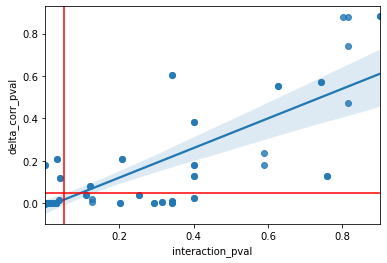

In [104]:

g = sns.regplot(data = df, x = 'interaction_pval', y = 'delta_corr_pval')
plt.axvline(x = 0.05, color = 'red')
plt.axhline(y = 0.05, color = 'red')
plt.show()

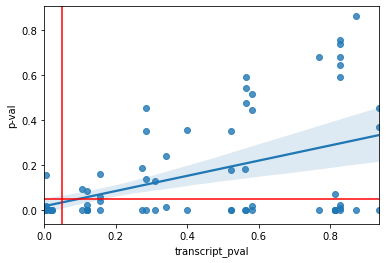

In [107]:
sns.regplot(data = df, x = 'transcript_pval', y = 'p-val')
plt.axvline(x = 0.05, color = 'red')
plt.axhline(y = 0.05, color = 'red')
plt.show()

In [106]:
df[df['p-val'] < 0.05]

,gene,cancer,interaction_coeff,condition_coeff,transcript_coeff,intercept,interaction_pval,condition_pval,transcript_pval,intercept_pval,Correlation,p-val,Tissue,Significant Correlation,delta_corr_pval,Significant Delta Correlation
1,BRAF,ccrcc,0.010412,-0.081675,0.004956,-0.113339,3.414814e-01,6.409939e-01,5.627178e-01,5.742203e-01,0.546805,1.776784e-09,Tumor,True,1.487778e-03,True
2,FAT1,ccrcc,-0.002134,0.743207,0.006258,-0.815901,4.017072e-01,2.601158e-04,1.696685e-02,3.223774e-05,0.409362,5.242074e-04,Normal,True,1.299626e-01,False
3,FAT1,ccrcc,-0.002134,0.743207,0.006258,-0.815901,4.017072e-01,2.601158e-04,1.696685e-02,3.223774e-05,0.600361,1.385610e-11,Tumor,True,1.299626e-01,False
4,IDH1,ccrcc,-0.002057,-0.414354,0.012565,-0.300409,3.414814e-01,1.174697e-05,3.436337e-21,1.087158e-04,0.741719,1.221902e-13,Normal,True,6.031357e-01,False
5,IDH1,ccrcc,-0.002057,-0.414354,0.012565,-0.300409,3.414814e-01,1.174697e-05,3.436337e-21,1.087158e-04,0.699513,1.037243e-16,Tumor,True,6.031357e-01,False
9,PIK3CA,ccrcc,0.019525,-0.230643,0.025151,-0.061899,4.017072e-01,2.049129e-01,3.095905e-01,6.624260e-01,0.521751,1.345012e-08,Tumor,True,2.555381e-02,True
10,PTEN,ccrcc,-0.044845,0.542478,0.054366,-0.890484,1.694057e-07,2.616658e-03,4.241792e-11,4.169225e-07,0.649130,9.225973e-10,Normal,True,1.786086e-01,False
11,PTEN,ccrcc,-0.044845,0.542478,0.054366,-0.890484,1.694057e-07,2.616658e-03,4.241792e-11,4.169225e-07,0.497284,7.861639e-08,Tumor,True,1.786086e-01,False
13,SPTA1,ccrcc,7.095579,1.207372,-5.901764,-1.172718,3.414814e-01,2.598936e-09,3.407768e-01,1.223506e-11,0.260784,1.087042e-02,Tumor,True,1.171187e-02,True
14,BRAF,endometrial,0.560156,-6.634918,-0.028917,0.377898,1.273634e-01,1.334145e-01,9.358392e-01,9.337822e-01,0.644945,6.699730e-12,Tumor,True,2.049911e-02,True
